In [1]:
from pyspark.sql import SparkSession

In [2]:
SparkSession

pyspark.sql.session.SparkSession

In [4]:
df = spark.read.option("inferSchema", "True").option("header", "True").csv("/shop/workspace/2019-Nov.csv")

In [5]:
df1 = spark.read.option("inferSchema", "True").option("header", "True").csv("/shop/workspace/2019-Oct.csv")

In [6]:
result_df = df.union(df1)

In [9]:
result_df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



In [10]:
result_df.show()

+--------------------+----------+----------+-------------------+--------------------+--------+------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand| price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+--------+------+---------+--------------------+
|2019-11-01 00:00:...|      view|   1003461|2053013555631882655|electronics.smart...|  xiaomi|489.07|520088904|4d3b30da-a5e4-49d...|
|2019-11-01 00:00:...|      view|   5000088|2053013566100866035|appliances.sewing...|  janome|293.65|530496790|8e5f4f83-366c-4f7...|
|2019-11-01 00:00:...|      view|  17302664|2053013553853497655|                null|   creed| 28.31|561587266|755422e7-9040-477...|
|2019-11-01 00:00:...|      view|   3601530|2053013563810775923|appliances.kitche...|      lg|712.87|518085591|3bfb58cd-7892-48c...|
|2019-11-01 00:00:...|      view|   1004775|2053013555631882655|elect

In [14]:
from pyspark.sql.functions import split, col

# DataFrame의 category_code 칼럼을 대, 중, 소 분류로 분할
shop = result_df.withColumn("category_list", split(col("category_code"), "\."))

# 대분류, 중분류, 소분류 칼럼 생성
shop = shop.withColumn("major_category", col("category_list")[0])
shop = shop.withColumn("intermediate_category", col("category_list")[1])
shop = shop.withColumn("minor_category", col("category_list")[2])

# 중복되는 칼럼 제거
shop = shop.drop("category_list")
# 결과 확인
shop.show()


+--------------------+----------+----------+-------------------+--------------------+--------+------+---------+--------------------+--------------+---------------------+--------------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand| price|  user_id|        user_session|major_category|intermediate_category|minor_category|
+--------------------+----------+----------+-------------------+--------------------+--------+------+---------+--------------------+--------------+---------------------+--------------+
|2019-11-01 00:00:...|      view|   1003461|2053013555631882655|electronics.smart...|  xiaomi|489.07|520088904|4d3b30da-a5e4-49d...|   electronics|           smartphone|          null|
|2019-11-01 00:00:...|      view|   5000088|2053013566100866035|appliances.sewing...|  janome|293.65|530496790|8e5f4f83-366c-4f7...|    appliances|       sewing_machine|          null|
|2019-11-01 00:00:...|      view|  17302664|2053013553853497655|           

In [15]:
type(shop)

pyspark.sql.dataframe.DataFrame

In [16]:
shop = shop.filter(col("category_code").isNotNull())

In [18]:
shop.count()

73577292

In [20]:
pip install matplotlib

     |████████████████████████████████| 9.2 MB 12.9 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 9.9 MB/s  eta 0:00:01
     |████████████████████████████████| 4.6 MB 36.6 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 42.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 35.7 MB/s eta 0:00:01
     |████████████████████████████████| 300 kB 40.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 37.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install --upgrade pandas


     |████████████████████████████████| 12.4 MB 18.2 MB/s eta 0:00:01
     |████████████████████████████████| 341 kB 34.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [28]:
shop.createOrReplaceTempView("shop")

In [29]:
query = """
SELECT major_category, count(*) AS cnt
FROM shop
WHERE event_type = 'purchase'
GROUP BY major_category
ORDER BY CNT DESC
LIMIT 10
"""

shop1 = spark.sql(query)

In [30]:
shop1.show()

+--------------+------+
|major_category|   cnt|
+--------------+------+
|   electronics|903859|
|    appliances|171786|
|     computers| 61400|
|       apparel| 21962|
|          auto| 21127|
|     furniture| 19618|
|  construction| 16324|
|          kids| 11508|
|   accessories|  3697|
|         sport|  2687|
+--------------+------+



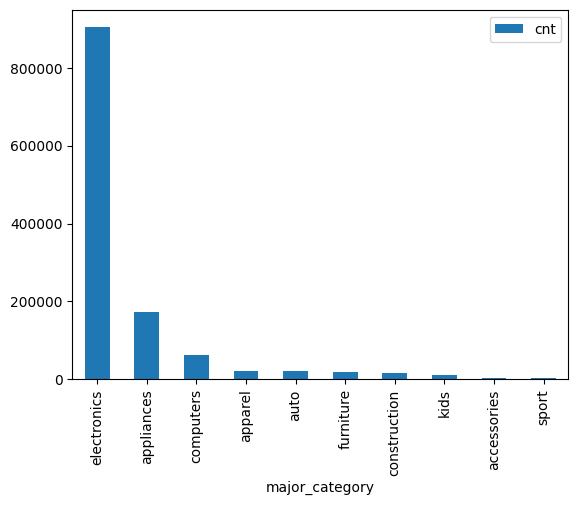

In [31]:
import matplotlib.pyplot as plt

shop1.toPandas().plot(kind="bar", x="major_category", y="cnt")
plt.show()

In [32]:
# 쇼핑몰 데이터 중 전자 기기를 판 브랜드 중 가장 높은 브랜드(상위10)는?
query = """
SELECT brand, count(*) AS cnt
FROM shop
WHERE major_category = 'electronics'
GROUP BY brand
ORDER BY CNT DESC
LIMIT 10
"""

shop2 = spark.sql(query)

In [33]:
shop2.show()

+-------+--------+
|  brand|     cnt|
+-------+--------+
|samsung|10990737|
|  apple| 9883299|
| xiaomi| 6290547|
| huawei| 2436474|
|   oppo| 1276797|
|   null|  715851|
|  casio|  612353|
|     lg|  553003|
|   sony|  542585|
|  artel|  454597|
+-------+--------+



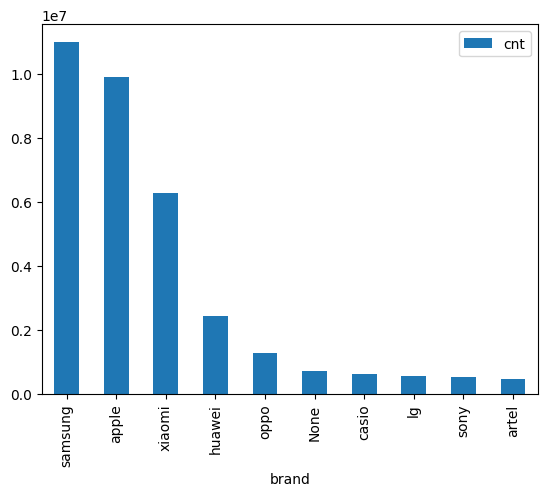

In [40]:
import matplotlib.pyplot as plt

shop2.toPandas().plot(kind="bar", x="brand", y="cnt")
plt.show()

In [41]:
# 뷰에서 카트로 넘어가는 전환율
query = """
SELECT
    SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) AS cart_count,
    SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END) AS view_count,
    (SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) / SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END)) AS cart_to_view_ratio
FROM
    shop
"""

shop3 = spark.sql(query)

In [42]:
shop3.show()

+----------+----------+--------------------+
|cart_count|view_count|  cart_to_view_ratio|
+----------+----------+--------------------+
|   2976555|  69365680|0.042911062069888165|
+----------+----------+--------------------+



In [43]:
# 카트에서 구매로 넘어가는 전환율
query2 = """
SELECT
    SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) AS purchase_count,
    SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) AS cart_count,
    (SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) / SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END)) AS purchase_to_cart_ratio
FROM
    shop
"""

shop4 = spark.sql(query2)

In [44]:
shop4.show()

+--------------+----------+----------------------+
|purchase_count|cart_count|purchase_to_cart_ratio|
+--------------+----------+----------------------+
|       1235057|   2976555|   0.41492833157794834|
+--------------+----------+----------------------+



In [49]:
query3 = """
SELECT event_type, count(*) AS CNT
FROM shop
GROUP BY event_type
ORDER BY 2
"""

shop5 = spark.sql(query3)

In [50]:
shop5.show()

+----------+--------+
|event_type|     CNT|
+----------+--------+
|  purchase| 1235057|
|      cart| 2976555|
|      view|69365680|
+----------+--------+



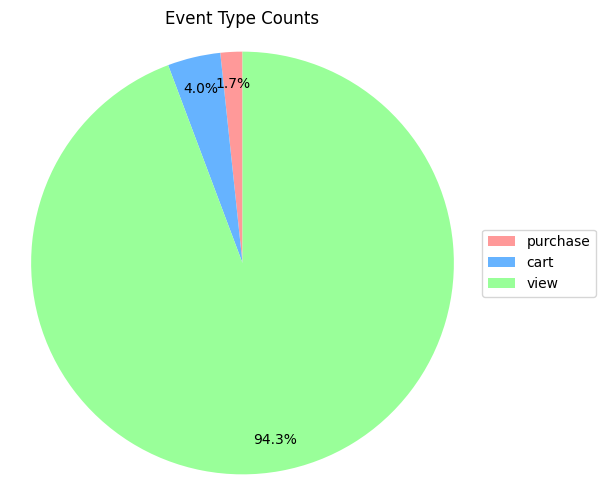

In [66]:
# 결과를 Pandas DataFrame으로 변환
shop5_df = shop5.toPandas()

# 파이차트 그리기
import matplotlib.pyplot as plt

# 데이터 준비
labels = shop5_df['event_type']
sizes = shop5_df['CNT']
colors = ['#ff9999', '#66b3ff', '#99ff99']

# 파이차트 그리기
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=None, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# 파이차트 라벨 설정 (파이차트 바깥쪽으로 이동)
plt.legend(labels, loc='center left', bbox_to_anchor=(1.0, 0.5))

# 제목 설정
plt.title('Event Type Counts')

# 파이차트 표시
plt.axis('equal')
plt.show()


In [62]:
query = """
SELECT
    (SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) / SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END)) AS view_to_cart,
    (SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) / SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END)) AS cart_to_purchase,
    (SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) / SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END)) AS view_to_purchase
FROM
    shop
WHERE
    event_type IN ('view', 'cart', 'purchase')
"""

shop_ratios = spark.sql(query)
shop_ratios.show()

+--------------------+-------------------+-------------------+
|        view_to_cart|   cart_to_purchase|   view_to_purchase|
+--------------------+-------------------+-------------------+
|0.042911062069888165|0.41492833157794834|0.01780501539089648|
+--------------------+-------------------+-------------------+



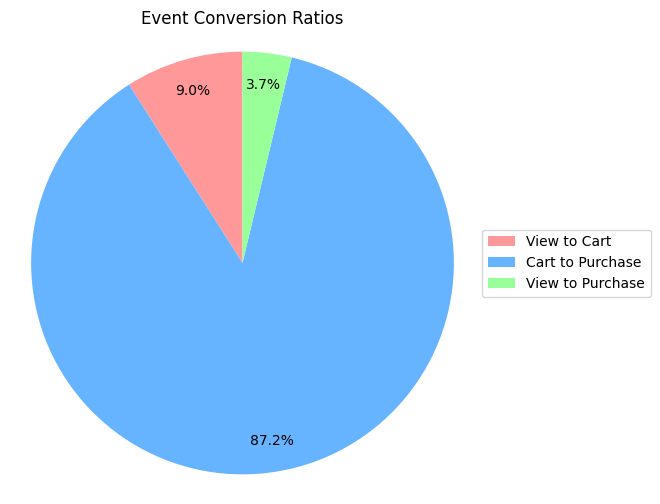

In [65]:
import matplotlib.pyplot as plt

# 파이차트 데이터
labels = ['View to Cart', 'Cart to Purchase', 'View to Purchase']
sizes = shop_ratios_df.iloc[0].values
colors = ['#ff9999', '#66b3ff', '#99ff99']

# 파이차트 그리기
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=None, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# 파이차트 라벨 설정 (파이차트 바깥쪽으로 이동)
plt.legend(labels, loc='center left', bbox_to_anchor=(1.0, 0.5))

# 제목 설정
plt.title('Event Conversion Ratios')

# 파이차트 표시
plt.axis('equal')
plt.show()
